In [ ]:
!pip install transformers
!pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.7/288.7 kB 20.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
from pathlib import Path

path = Path("/content/gdrive/MyDrive/freq_data/bitvavo")
pair_files = os.listdir(path)
print(pair_files)

['1INCH_EUR-1h.json', '1INCH_EUR-5m.json', 'ACH_EUR-1h.json', 'ACH_EUR-5m.json', 'ADX_EUR-5m.json', 'ADX_EUR-1h.json', 'ALGO_EUR-1h.json', 'ALICE_EUR-5m.json', 'ALICE_EUR-1h.json', 'ALGO_EUR-5m.json', 'ALPHA_EUR-1h.json', 'ALPHA_EUR-5m.json', 'ANKR_EUR-1h.json', 'ANKR_EUR-5m.json', 'APE_EUR-5m.json', 'APE_EUR-1h.json', 'AR_EUR-5m.json', 'AR_EUR-1h.json', 'APT_EUR-1h.json', 'APT_EUR-5m.json', 'ARB_EUR-5m.json', 'ARK_EUR-5m.json', 'ATA_EUR-1h.json', 'AUDIO_EUR-1h.json', 'ATA_EUR-5m.json', 'AUDIO_EUR-5m.json', 'AXS_EUR-1h.json', 'AVAX_EUR-5m.json', 'AXS_EUR-5m.json', 'BAL_EUR-1h.json', 'BAL_EUR-5m.json', 'BTT_EUR-1h.json', 'BTT_EUR-5m.json', 'CHR_EUR-5m.json', 'CVX_EUR-5m.json', 'CVC_EUR-5m.json', 'DENT_EUR-5m.json', 'DCR_EUR-5m.json', 'DIA_EUR-5m.json', 'DGB_EUR-5m.json', 'DOGE_EUR-5m.json', 'DOT_EUR-5m.json', 'DYDX_EUR-5m.json', 'DUSK_EUR-5m.json', 'EGLD_EUR-5m.json', 'EGLD_EUR-1h.json', 'ELF_EUR-5m.json', 'ENJ_EUR-5m.json', 'ENS_EUR-1h.json', 'ENS_EUR-5m.json', 'T_EUR-1h.json', 'GLMR_E

### Load Data and transform to DataFrame

In [ ]:
import itertools
import logging
from operator import itemgetter
from typing import Dict, List

import numpy as np
import pandas as pd
from pandas import DataFrame, to_datetime
import ccxt

logger = logging.getLogger(__name__)


def ohlcv_to_dataframe(ohlcv: list, timeframe: str, pair: str, *,
                       fill_missing: bool = True, drop_incomplete: bool = True) -> DataFrame:
    """
    Converts a list with candle (OHLCV) data (in format returned by ccxt.fetch_ohlcv)
    to a Dataframe
    :param ohlcv: list with candle (OHLCV) data, as returned by exchange.async_get_candle_history
    :param timeframe: timeframe (e.g. 5m). Used to fill up eventual missing data
    :param pair: Pair this data is for (used to warn if fillup was necessary)
    :param fill_missing: fill up missing candles with 0 candles
                         (see ohlcv_fill_up_missing_data for details)
    :param drop_incomplete: Drop the last candle of the dataframe, assuming it's incomplete
    :return: DataFrame
    """
    logger.debug(f"Converting candle (OHLCV) data to dataframe for pair {pair}.")
    cols = ['date', 'open', 'high', 'low', 'close', 'volume']
    df = DataFrame(ohlcv, columns=cols)

    df['date'] = to_datetime(df['date'], unit='ms', utc=True)

    # Some exchanges return int values for Volume and even for OHLC.
    # Convert them since TA-LIB indicators used in the strategy assume floats
    # and fail with exception...
    df = df.astype(dtype={'open': 'float', 'high': 'float', 'low': 'float', 'close': 'float',
                          'volume': 'float'})
    return clean_ohlcv_dataframe(df, timeframe, pair,
                                 fill_missing=fill_missing,
                                 drop_incomplete=drop_incomplete)


def clean_ohlcv_dataframe(data: DataFrame, timeframe: str, pair: str, *,
                          fill_missing: bool, drop_incomplete: bool) -> DataFrame:
    """
    Cleanse a OHLCV dataframe by
      * Grouping it by date (removes duplicate tics)
      * dropping last candles if requested
      * Filling up missing data (if requested)
    :param data: DataFrame containing candle (OHLCV) data.
    :param timeframe: timeframe (e.g. 5m). Used to fill up eventual missing data
    :param pair: Pair this data is for (used to warn if fillup was necessary)
    :param fill_missing: fill up missing candles with 0 candles
                         (see ohlcv_fill_up_missing_data for details)
    :param drop_incomplete: Drop the last candle of the dataframe, assuming it's incomplete
    :return: DataFrame
    """
    # group by index and aggregate results to eliminate duplicate ticks
    data = data.groupby(by='date', as_index=False, sort=True).agg({
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'max',
    })
    # eliminate partial candle
    if drop_incomplete:
        data.drop(data.tail(1).index, inplace=True)
        logger.debug('Dropping last candle')

    if fill_missing:
        return ohlcv_fill_up_missing_data(data, timeframe, pair)
    else:
        return data

def timeframe_to_minutes(timeframe: str) -> int:
    """
    Translates the timeframe interval value written in the human readable
    form ('1m', '5m', '1h', '1d', '1w', etc.) to the number
    of minutes for one timeframe interval.
    from "1686240000000" to "2023-06-18 18:45:00+00:00"
    """
    return ccxt.Exchange.parse_timeframe(timeframe) // 60

def ohlcv_fill_up_missing_data(dataframe: DataFrame, timeframe: str, pair: str) -> DataFrame:
    """
    Fills up missing data with 0 volume rows,
    using the previous close as price for "open", "high" "low" and "close", volume is set to 0
    """
    # from freqtrade.exchange import timeframe_to_minutes

    ohlcv_dict = {
        'open': 'first',
        'high': 'max',
        'low': 'min',
        'close': 'last',
        'volume': 'sum'
    }
    timeframe_minutes = timeframe_to_minutes(timeframe)
    # Resample to create "NAN" values
    df = dataframe.resample(f'{timeframe_minutes}min', on='date').agg(ohlcv_dict)

    # Forwardfill close for missing columns
    df['close'] = df['close'].fillna(method='ffill')
    # Use close for "open, high, low"
    df.loc[:, ['open', 'high', 'low']] = df[['open', 'high', 'low']].fillna(
        value={'open': df['close'],
               'high': df['close'],
               'low': df['close'],
               })
    df.reset_index(inplace=True)
    len_before = len(dataframe)
    len_after = len(df)
    pct_missing = (len_after - len_before) / len_before if len_before > 0 else 0
    if len_before != len_after:
        message = (f"Missing data fillup for {pair}: before: {len_before} - after: {len_after}"
                   f" - {pct_missing:.2%}")
        if pct_missing > 0.01:
            logger.info(message)
        else:
            # Don't be verbose if only a small amount is missing
            logger.debug(message)
    return df

In [ ]:
#file format: '1INCH_EUR-1h.json'
import json
from pathlib import Path

#file format: '1INCH_EUR-1h.json'
import json
from pathlib import Path

def read_json_files(folder_path):
    columns = ['date', 'open', 'high', 'low', 'close', 'volume']
    combined_df = pd.DataFrame(columns=columns)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.json') and '1h' in  file_name:
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r') as file:
                data = json.load(file)
                new_df = ohlcv_to_dataframe(data, '1h', '*/EUR')

            combined_df = pd.concat([combined_df, new_df], ignore_index=True)
    return combined_df

df = read_json_files(path)
df.head()


1INCH_EUR-1h.json
ACH_EUR-1h.json
ADX_EUR-1h.json
ALGO_EUR-1h.json
ALICE_EUR-1h.json
ALPHA_EUR-1h.json
ANKR_EUR-1h.json
APE_EUR-1h.json
AR_EUR-1h.json
APT_EUR-1h.json
ATA_EUR-1h.json
AUDIO_EUR-1h.json
AXS_EUR-1h.json
BAL_EUR-1h.json
BTT_EUR-1h.json
EGLD_EUR-1h.json
ENS_EUR-1h.json
T_EUR-1h.json
GLMR_EUR-1h.json
HOT_EUR-1h.json
ARB_EUR-1h.json
ARK_EUR-1h.json
AVAX_EUR-1h.json
CHR_EUR-1h.json
CVC_EUR-1h.json
CVX_EUR-1h.json
DCR_EUR-1h.json
DENT_EUR-1h.json
DIA_EUR-1h.json
DGB_EUR-1h.json
DOGE_EUR-1h.json
ELF_EUR-1h.json
DOT_EUR-1h.json
DYDX_EUR-1h.json
DUSK_EUR-1h.json
ENJ_EUR-1h.json
NEO_EUR-1h.json
ETH_EUR-1h.json
ETC_EUR-1h.json
LTC_EUR-1h.json
XLM_EUR-1h.json
XEM_EUR-1h.json
POWR_EUR-1h.json
SRM_EUR-1h.json
BTC_EUR-1h.json
XRP_EUR-1h.json
FTT_EUR-1h.json
TRX_EUR-1h.json
FET_EUR-1h.json
RNDR_EUR-1h.json
STX_EUR-1h.json
FXS_EUR-1h.json
MTL_EUR-1h.json
REQ_EUR-1h.json
PERP_EUR-1h.json
SAND_EUR-1h.json
GRT_EUR-1h.json
WTC_EUR-1h.json
KMD_EUR-1h.json
VET_EUR-1h.json
ONT_EUR-1h.json
LINK_E

,date,open,high,low,close,volume
0,2023-05-02 00:00:00+00:00,0.41435,0.41435,0.41412,0.41412,120.621372
1,2023-05-02 01:00:00+00:00,0.41362,0.41362,0.41206,0.41206,24.585622
2,2023-05-02 02:00:00+00:00,0.41366,0.41366,0.41366,0.41366,48.228315
3,2023-05-02 03:00:00+00:00,0.41366,0.41366,0.41366,0.41366,0.000000
4,2023-05-02 04:00:00+00:00,0.41366,0.41366,0.41366,0.41366,0.000000


In [ ]:
len(df)

358050

Simple Moving Average VS. TimeSeriesTransformers

In [ ]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

configuration = TimeSeriesTransformerConfig(prediction_length=24, context_length=240, num_time_features=5, lags_sequence=[0])
# configuration.d_model = 64
print(configuration)
# Randomly initializing a model (with random weights) from the configuration
model = TimeSeriesTransformerModel(configuration)
configuration = model.config
# for name, param in model.named_parameters():
#   print(name)

TimeSeriesTransformerConfig {
  "activation_dropout": 0.1,
  "activation_function": "gelu",
  "attention_dropout": 0.1,
  "cardinality": [
    0
  ],
  "context_length": 240,
  "d_model": 64,
  "decoder_attention_heads": 2,
  "decoder_ffn_dim": 32,
  "decoder_layerdrop": 0.1,
  "decoder_layers": 2,
  "distribution_output": "student_t",
  "dropout": 0.1,
  "embedding_dimension": [
    0
  ],
  "encoder_attention_heads": 2,
  "encoder_ffn_dim": 32,
  "encoder_layerdrop": 0.1,
  "encoder_layers": 2,
  "feature_size": 8,
  "init_std": 0.02,
  "input_size": 1,
  "is_encoder_decoder": true,
  "lags_sequence": [
    0
  ],
  "loss": "nll",
  "model_type": "time_series_transformer",
  "num_dynamic_real_features": 0,
  "num_parallel_samples": 100,
  "num_static_categorical_features": 0,
  "num_static_real_features": 0,
  "num_time_features": 5,
  "prediction_length": 24,
  "scaling": "mean",
  "transformers_version": "4.31.0",
  "use_cache": true
}



### Time2Vec

In [ ]:

from datetime import datetime

class Time2Vec:
  def transform(df):
    return np.array([[pd.to_datetime(dt).hour, pd.to_datetime(dt).day, pd.to_datetime(dt).month] for dt in df])

datetime_str = "2023-06-18 20:00:00+00:00"
dt = datetime.fromisoformat(datetime_str)
vector_representation = Time2Vec.transform(np.array([dt, dt]))

print(vector_representation)


[[20 18  6]
 [20 18  6]]


## Dataset

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, df, past_length=240, future_length=24):
        self.df = df
        self.past_length = past_length
        self.future_length = future_length

    def __len__(self):
        return len(self.df) - self.past_length - self.future_length + 1

    def __getitem__(self, idx):
        window = self.past_length + self.future_length

        past_values = self.df[['open', 'high', 'low', 'close', 'volume']].iloc[idx : idx + self.past_length].values
        past_time_features = Time2Vec.transform(self.df[['date']].iloc[idx : idx + self.past_length].values)
        """
        past_observed_mask (torch.BoolTensor of shape (batch_size, sequence_length)
        or (batch_size, sequence_length, input_size), optional)
        Boolean mask to indicate which past_values were observed and which were missing.
        Mask values selected in [0, 1]:
        """
        past_observed_mask = ~(
            self.df[['volume']][idx : idx + self.past_length].isna()
            | (self.df[['volume']][idx : idx + self.past_length] == 0)
        ).values.astype(int)

        # For future_values, let's assume we are predicting the 'close' price for the next day
        # future_values = torch.tensor(df['close'].shift(-1).values, dtype=torch.float32).unsqueeze(1)
        future_values = self.df[['open', 'high', 'low', 'close', 'volume']].iloc[idx + self.past_length : idx + window].values
        future_time_features = Time2Vec.transform(self.df[['date']].iloc[idx + self.past_length : idx + window].values)

        batch = {
            'past_values': torch.tensor(past_values, dtype=torch.float32),
            'past_time_features': torch.tensor(past_time_features, dtype=torch.float32).squeeze(),
            'past_observed_mask': torch.tensor(past_observed_mask, dtype=torch.int32),
            'future_values': torch.tensor(future_values, dtype=torch.float32),
            'future_time_features': torch.tensor(future_time_features, dtype=torch.float32).squeeze(),
        }

        return batch

Test TimeSeries Dataset

In [ ]:
past_length = 240
future_length = 24

ds = TimeSeriesDataset(df, past_length, future_length)
sample = ds[0]

print(sample['past_values'].shape) # (batch_size, sequence_length, input_size)
print(sample['past_time_features'].shape) # (batch_size, sequence_length, num_features)
print(sample['past_observed_mask'].shape) # (batch_size, sequence_length, input_size)
print(sample['future_values'].shape) # (batch_size, prediction_length, input_size)
print(sample['future_time_features'].shape) # (batch_size, prediction_length, num_features)

torch.Size([240, 5])
torch.Size([240, 3])
torch.Size([240, 1])
torch.Size([24, 5])
torch.Size([24, 3])


In [1]:
outputs = model(
  past_values=sample["past_values"].unsqueeze(0),
  past_time_features=sample["past_time_features"].unsqueeze(0),
  past_observed_mask=sample["past_observed_mask"].unsqueeze(0),
  future_values=sample["future_values"].unsqueeze(0),
  future_time_features=sample["future_time_features"].unsqueeze(0),
)

In [ ]:
outputs.last_hidden_state.shape , sample["future_values"].shape

In [ ]:
linear_layer = torch.nn.Linear(64, 5)
generated_data = linear_layer(outputs.last_hidden_state)
generated_data.shape

In [ ]:
target_values = sample["future_values"]
criterion = torch.nn.MSELoss()
loss = criterion(generated_data.squeeze(), target_values)
loss.item()

Time Seiers Analysis

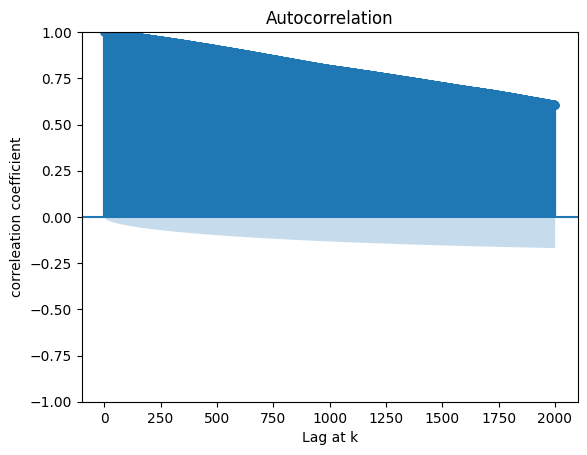

In [ ]:
from statsmodels.graphics import  tsaplots

# rcParams['figure.figsize'] = 10, 6
fig = tsaplots.plot_acf(df['close'], lags=2000)

plt.xlabel("Lag at k")
plt.ylabel('correleation coefficient')
plt.show()

## Split Data K-Fold

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
print(tscv)

train_df = df.iloc[train_index]
test_ddf = df.iloc[test_index]
# test_df, val_df = [], []

past_length = 240
future_length = 24

train_dataset = TimeSeriesDataset(train_df, past_length, future_length)
# test_dataset = TimeSeriesDataset(test_df, past_length, future_length)
val_dataset = TimeSeriesDataset(val_df, past_length, future_length)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5


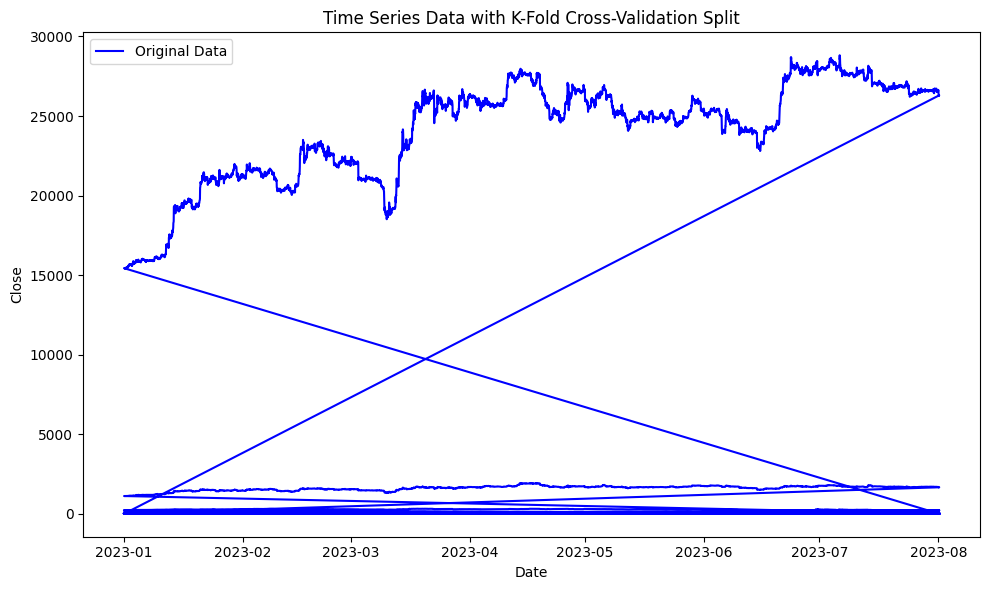

In [ ]:
for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    print(f"Fold: {fold}")
    # print(train_index)
    # print(test_index)
import matplotlib.pyplot as plt
# Create a figure to visualize the k-fold split
plt.figure(figsize=(10, 6))
plt.title("Time Series Data with K-Fold Cross-Validation Split")

# Plot the entire time series data
plt.plot(df['date'], df['close'], label='Original Data', color='blue')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

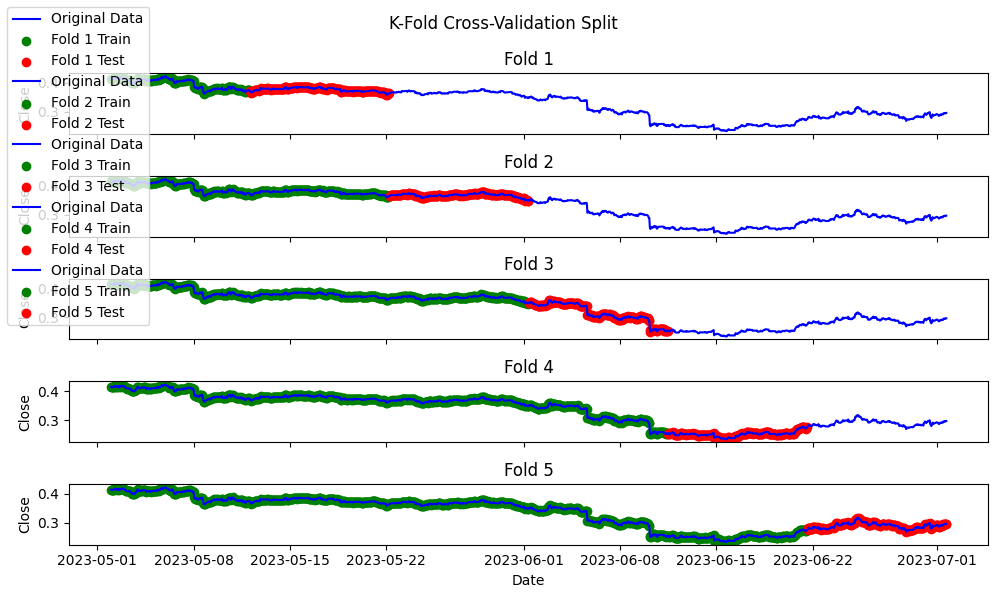

In [ ]:
# Create a figure to visualize the k-fold split
n_splits = 5
fig, axs = plt.subplots(n_splits, 1, figsize=(10, 6), sharex=True, sharey=True)
fig.suptitle("K-Fold Cross-Validation Split")

# Loop for k-fold cross-validation
for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    # Get the training and testing data for this fold
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

    # Plot the training and testing data for this fold
    axs[fold-1].plot(df['date'], df['close'], label='Original Data', color='blue')
    axs[fold-1].scatter(train_data['date'], train_data['close'], label=f"Fold {fold} Train", color='green')
    axs[fold-1].scatter(test_data['date'], test_data['close'], label=f"Fold {fold} Test", color='red')

    # Customize the subplot
    axs[fold-1].set_title(f"Fold {fold}")
    axs[fold-1].set_ylabel('Close')

# Customize the x-axis label for the last subplot
axs[n_splits - 1].set_xlabel('Date')

# Add a common legend for all subplots
fig.legend(loc='upper left')

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## Train loop

In [ ]:
import torch.nn as nn
import torch.optim as optim
# Assuming you have a list of sequences with an input size of (32, 128, 5)
num_epochs = 12
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
linear_layer = torch.nn.Linear(64, 5).to(device)
model.to(device)
train_losses = []
val_losses = []
# For an epoch in a range
for epoch in range(num_epochs):
    # model dot train
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:

        # Do the Forward pass
        outputs = model(
            past_values=batch["past_values"].to(device),
            past_time_features=batch["past_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_values=batch["future_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
        )

        # Calculate the loss
        target_values = batch["future_values"].to(device)
        generated_values = linear_layer(outputs.last_hidden_state)
        loss = criterion(generated_values, target_values)
        total_loss += loss.item()
        print(loss.item())

        # optimizer zerooo graaad
        optimizer.zero_grad()
        # loooooooooooooos backward
        loss.backward()
        # optimizer step, step stepp
        optimizer.step()

    # Calculate average training loss for this epoch
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_dataloader):
            # Forward pass eval
            outputs = model(
                past_values=batch["past_values"].to(device),
                past_time_features=batch["past_time_features"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                future_values=batch["future_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
            )
            target_values = batch["future_values"].to(device)
            generated_values = linear_layer(outputs.last_hidden_state)

            val_loss = criterion(generated_values, target_values)
            total_val_loss += val_loss.item()

    # Calculate average validation loss for this epoch
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f"{datetime.now()} Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")


# After training, the model should be ready for inference and forecasting.
# You can now use the model to predict future values for new data.

In [ ]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses):
    epochs = len(train_losses)

    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs. Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(train_losses, val_losses)


## Evaluate

In [ ]:
# Test Set Evaluation
model.eval()
total_test_loss = 0.0
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        # Forward pass
        outputs = model.generate(
            past_values=batch["past_values"],
            past_time_features=batch["past_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            future_time_features=batch["future_time_features"],
        )
        target_values = batch["future_values"].to(device)
        generated_values = linear_layer(outputs.last_hidden_state)

        test_loss = criterion(generated_values, target_values)
        total_test_loss += test_loss.item()

# Calculate average test loss
avg_test_loss = total_test_loss / len(test_dataloader)
print(f"Test Loss: {avg_test_loss}")

mean_prediction = outputs.sequences.mean(dim=1)


Generate future values

In [ ]:
outputs = model(
  past_values=sample["past_values"].unsqueeze(0).to(device),
  past_time_features=sample["past_time_features"].unsqueeze(0).to(device),
  past_observed_mask=sample["past_observed_mask"].unsqueeze(0).to(device),
  future_values=sample["future_values"].unsqueeze(0).to(device),
  future_time_features=sample["future_time_features"].unsqueeze(0).to(device),
)
generated_values = linear_layer(outputs.last_hidden_state)
generated_values_sequence = generated_values.detach().cpu().numpy()


In [ ]:
generated_values_sequence.shape, sample["future_values"].unsqueeze(0).shape

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vectors_over_time(vector1, vector2, feature_names=None):
    num_time_steps = vector1.shape[1]
    num_features = vector1.shape[2]

    if feature_names is None:
        feature_names = [f"Feature {i + 1}" for i in range(num_features)]

    time_steps = np.arange(1, num_time_steps + 1)

    plt.figure(figsize=(10, 6))

    for feature_idx in range(num_features):
        plt.plot(time_steps, vector1[0, :, feature_idx], label=f"{feature_names[feature_idx]} (Generated)")
        plt.plot(time_steps, vector2[0, :, feature_idx], linestyle='dashed', label=f"{feature_names[feature_idx]} (Ground Truth)")

    plt.xlabel('Time Steps')
    plt.ylabel('Values')
    plt.title('Vectors over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']

plot_vectors_over_time(generated_values_sequence, sample["future_values"].unsqueeze(0), feature_names)


In [ ]:
!pip install mplfinance

In [ ]:
import pandas as pd
import mplfinance as mpf

def plot_candlesticks(vector1, vector2, feature_names=None):
    num_time_steps = vector1.shape[1]
    num_features = vector1.shape[2]

    if feature_names is None:
        feature_names = [f"Feature {i + 1}" for i in range(num_features)]

    time_steps = pd.date_range(start="2023-08-01", periods=num_time_steps, freq="H")

    df1 = pd.DataFrame(data=vector1[0], columns=feature_names, index=time_steps)
    df2 = pd.DataFrame(data=vector2[0], columns=feature_names, index=time_steps)

    # Convert dataframes to candlestick format (Open, High, Low, Close)
    ohlc_data1 = df1[["Open", "High", "Low", "Close"]]
    ohlc_data2 = df2[["Open", "High", "Low", "Close"]]

    # Plot the candlesticks
    fig, axes = mpf.plot(ohlc_data1, type='candle', style='charles', title="Vector 1 as Candlesticks", returnfig=True)
    mpf.plot(ohlc_data2, type='candle', style='charles', title="Vector 2 as Candlesticks", ax=axes)

# Example usage:
vector1 = np.random.rand(1, 24, 5)  # Replace this with your actual vector data
vector2 = np.random.rand(1, 24, 5)  # Replace this with your actual vector data
feature_names = ['Open', 'High', 'Low', 'Close', 'Volume']

plot_candlesticks(generated_values_sequence, sample["future_values"].unsqueeze(0), feature_names)
